<a href="https://colab.research.google.com/github/NaimaZouidi/Frenshi-chatbot/blob/main/Frenshi_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frenshi Chatbot

This notebook trains a chatbot called Frenshi on the administrative formalities in France for foreign students to help them during their stay! It proposes FR and EN versions to help these later regardless of whether they can speak French or not!

# Set-up enviroment
To run this colab you will need to import some python modules such as Tensorflow, pandas, etc.



In [1]:
import tensorflow as tf
import json
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAvgPool1D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

# Help-in functions

This function creates an NLP model with an LSTM transformer.


```
input_shape: is the length of the user's input.
output_len: is the number of output tags or classes.
```



In [59]:
def createNLPModel(input_shape, output_len):
  i = Input(shape=(input_shape))
  x = Embedding(vocabulary + 1, 10)(i)
  x = LSTM(10, return_sequences=True)(x)
  x = Flatten()(x)
  x = Dense(output_len, activation="softmax")(x)
  model = Model(i, x)
  return model

# Preparing Data set
In order to train Frenshi we need to create a dataset, a json file here, which will hold user's questions and the best answers to it underneath a tag or class such as: `greetingDay FR inputs/answers`, `goodbyeDay FR inputs/answers,` etc. In order to help foreign students regadless of whether they can speak French or not we will create an FR and EN versions of all tags/classes of our dataset!


In [58]:
%%writefile dataset.json
{"intents":
[
   {
      "tag": "greetingDay FR",
      "input": ["Salut !", "Salut Frenshi", "Bonjour", "Bonjour Frenshi", "Coucou", "coucou Frenshi", "Frenshi!"],
      "responses" : ["Bienvenue ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale",
      "Bonjour ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale",
      "Oh salut ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale"]
    },
    {
      "tag": "greetingEvening FR",
      "input": ["Bonsoir", "Bonsoir Frenshi!"],
      "responses" : ["Bienvenue ! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale",
      "Bonsoir ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale",
      "Oh salut ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale"]
    },
    {
      "tag": "goodbyeDay FR",
      "input": ["ça marche!", "Ca marche!", "ça marche! Bonne journée", "ça marche ! Merci", "ça marche ! Au revoir", "ça marche ! Merci beaucoup", "Ca marche ! Bonne journée", "Ca marche ! Merci", "Ca marche ! Au revoir", "Ca marche ! Merci beaucoup", "Top !", "Top ! Bonne journée", "Top ! Merci", "Top ! Merci beaucoup", "Top ! Au revoir", "D'accord", "D'accord ! Au revoir !", "D'accord! Merci !", "D'accord ! Merci beaucoup", "D'accord ! Bonne journée", "Super !", "Super ! Merci !", "Super ! merci beaucoup", "Super ! Au revoir", "Super ! bonne journée", "Au revoir !", "Au revoir Frenshi !", "Merci beaucoup ! Au revoir", "Merci beaucoup ! Au revoir Frenshi", "Oh ! Merci beaucoup", "Oh ! Merci beaucoup Frenshi", "Merci beaucoup ! Bonne journée", "Merci beaucoup ! Bonne journée Frenshi", "Merci !", "Merci Frenshi !", "Bonne journée", "Bonne journée Frenshi !"],
      "responses" : ["Au revoir ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !",
      "Je t'en prie ! N'hésitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches administratives en France ! A plus.",
      "Bonne journée ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !"]
    },
    {
      "tag": "goodbyeEvening FR",
      "input": ["D'accord ! Bonne soirée", "Super ! Bonne soirée", "Ca marche ! Bonne soirée", "Top ! Bonne soirée", "Merci beaucoup ! Bonne soirée", "Merci beaucoup ! Bonne soirée Frenshi !", "Merci ! Bonne soirée", "Merci ! Bonne soirée Frenshi !", "Bonne soirée", "Bonne soirée Frenshi !"],
      "responses" : ["Au revoir ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France!",
      "Je t'en prie ! N'hésitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches administratives en France!",
      "Bonne journée ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !",
      "Bonne soirée ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !"]
    },
    {
      "tag": "Civil state FR",
      "input": ["état civil", "Etat civil", "C'est quoi l'état civil?", "Quel document pour l'état civil?", "Quelle pièce justificative pour l'état civil?", "Que ce que c'est l'état civil?", "Que-est ce que l'état civil?", "savoir plus sur l'état civil", "Je souhaite savoir plus sur l'état civil?"],
      "responses":["La pièce justificative à fournir pour l'état civil peut dépendre de démarche administratif à faire, à savoir: une démarche pour un titre de séjour ou la sécurité sociale. Veuillez s'il vous plait préciser cela dans votre question. Merci !",
      "Le document à fournir pour l'état civil peut varier en fonction de la démarche administratif à faire, telle qu'une demande de titre de séjour ou de sécurité sociale. Veuillez s'il vous plait préciser cela dans votre question. Merci !"]
    },
    {
      "tag": "Resident permit FR",
      "input":["Titre de séjour", "Que ce que c'est un titre de séjour?", "Pourquoi un titre de séjour?", "Quel titre de séjour faut-t-il demander?", "Quel titre de séjour pour un étudiant étranger?", "C'est quoi un titre de séjour?", "Qu’est-ce que un titre de séjour?", "Dois-je demande un titre de séjour?", "Le titre de séjour, c'est quoi?"],
      "responses": ["Le titre de séjour est un document qui vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat.",
      "En France, le titre de séjour vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat.",
      "Le titre de séjour en France justifie vos droits et vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat."]
    },
    {
      "tag": "Documents for Resident permit FR",
      "input": ["Je souhaite savoir plus sur les pièces justificatifs pour demander un titre de séjour", "Je souhaite savoir un peu plus sur les documents à fournir pour demander un titre de séjour", "Je souhaite savoir plus sur les pièces justificatifs pour formuler ma demande de titre de séjour", "Quelles sont les pièces justificatives pour demander un titre de séjour?", "Quelles sont les pièces justificatives à fournir pour demander un titre de séjour?", "Comment formuler ma demande de titre de séjour?", "Quels sont les documents nécessaires pour demander un titre de séjour?", "Documents nécessaires titre de séjour", "Pièces justificatives titre de séjour", "Documents à fournir titre de séjour"],
      "responses": ["Voici la liste des pièces justificatives que vous aurez besoin pour préparer de votre demande de titre de séjour:\n1. Un justificatif d'état civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières.",
      "Quant aux pièces justificatives que vous aurez besoin pour préparer votre demande de titre de séjour, ils sont les suivantes:\n1. Un justificatif d'état civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières.",
      "Pour formuler votre demande de titre de séjour de titre de séjour ous aurez besoin des pièces justificatives suivantes:\n1. Etat civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières."]
    },
    {
      "tag": "Civil state resident permit FR",
      "input": ["Je souhaite savoir quel justificatif pour l'état civil pour une demande de titre de séjour?", "Justificatif état civil titre de séjour", "Etat civil titre de séjour", "Qu’est-ce que le justificatif de l'état civil pour un titre de séjour?", "C'est quoi le justificatif d'état civil pour un titre de séjour?", "Le justificatif d'état civil pour un titre de séjour, c'est quoi?", "Document à fournir pour l'état civil pour ma demande de titre de séjour", "Quel document à fournir pour l'état civil pour ma demande titre de séjour?", "Quel est le document à fournir pour l'état civil pour ma demande de titre de séjour?", "Pièce justificative état civil titre de séjour", "Quelle pièce justificative pour l'état civil pour ma demande de titre de séjour?", "Document à fournir pour l'état civil titre de séjour", "Quel est le document à fournir pour l'état civil pour ma demande de titre de séjour?", "Quelle est la pièce justificative à fournir pour l'état civil pour ma demande de titre de séjour?"],
      "responses": ["Pour l'état civil il vaut faut un titre de séjour en cours de validité, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de séjour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'entrée et aux visas y a compris ton visa long séjour VTS.",
      "Quant à l'état civil il vaut faut un titre de séjour en cours de validité, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de séjour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'entrée et aux visas y a compris ton visa long séjour VTS."]
    },
    {
      "tag": "Identity photograph FR",
      "input": ["Quelle photographie d'identité?", "Photographie d'identité", "Format de photographie d'identité", "Quelle format pour la photographie d'identité", "Photo d'identité", "Quelle photo d'identité?", "Format de photo d'identité", "Quelle format pour le photo d'identité?"],
      "responses":["La photographie d'identité prend la forme une e-photo datant de moins de 6 mois.",
      "La photographie d'identité prend la forme d'une e-photo et doit avoir été prise il y a moins de 6 mois."]
    },
    {
      "tag": "E-photo FR",
      "input": ["C'est quoi un e-photo", "e-photo", "Qu’est-ce que un e-photo?", "Que ce que c'est un e-photo?", "L'e-photo, c'est quoi?", "Savoir plus sur l'e-photo", "Je souhaite savoir plus sur l'e-photo"],
      "responses": ["L'e-photo est une photo d'identité dématérialisée avec une signature numérique.",
      "L'e-photo présente une photo d'identité dématérialisée avec une signature numérique."]
    },
    {
      "tag": "Reason for staying FR",
      "input": ["Quels sont les documents pour le motif de mon séjour?", "Je souhaite savoir plus sur les documents à fournir pour le motif de mon séjour?", "Motif de séjour", "savoir plus sur le motif de titre de séjour", "C'est quoi le motif de séjour?", "Le motif de séjour, c'est quoi?", "Quelles sont les pièces justificatives pour le motif de séjour?", "Motif de séjour étudiant", "Quels sont les documents à fournir pour le motif de séjour?", "Quelles sont les Pièces justificatives à fournir pour le motif de séjour?", "Qu’est-ce que le motif de séjour?", "Que ce que c'est le motif de séjour?"],
      "responses": ["Concernant le motif de votre séjour, il faut fournir une certificat d'inscription ou justificatif de réinscription auprès de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous solliciter est chercheur vous devez joindre également une convention d'accueil de laboratoire de recherche dont laquelle vous allez effectuer votre thèse de doctorat.",
      "Pour le motif de votre séjour il s'agit de fournir une certificat d'inscription ou justificatif de réinscription auprès de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous solliciter est chercheur vous devez joindre également une convention d'accueil de laboratoire de recherche dont laquelle vous allez effectuer votre thèse de doctorat."]
    },
    {
      "tag":"Apply for resident permit FR",
      "input": ["Je souhaite demander un titre de séjour", "Comment effectuer ma démarche de titre de séjour?", "Comment demander un titre de séjour?" , "Demander un titre de séjour", "Où déposer ma demande de titre de séjour?", "Comment solliciter un titre de séjour?", "Je sollicite un titre de séjour"],
      "responses": ["Si vous souhaitez effectuer votre démarche de titre de séjour vous pouvez précéder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "Pour effectuer votre démarche de titre de séjour vous pouvez précéder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "Pour demander un titre de séjour vous pouvez précéder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/"]
    },
    {
      "tag": "Proof of address FR",
      "input": ["Quel est le justificatif de domicile?", "Le Justificatif de domicile, c'est quoi?", "Justificatif de domicile", "le justificatif de domicile", "Que ce que c'est le justificatif de domicile?", "C'est quoi le justificatif de domicile?", "Qu'est-ce que le justificatif de domicile?"],
      "responses": ["Le justificatif de domicile peut prendre plusieurs formes. Veuillez s'il vous plait me préciser si vous êtes locataire, héberger à l’hôtel ou chez un particulier. Merci !",
      "Pour le justificatif de domicile, il peut prendre plusieurs formes. Veuillez s'il vous plait me préciser si vous êtes locataire, héberger à l’hôtel ou chez un particulier. Merci !"]
    },
    {
      "tag": "A student renting a flat FR",
      "input": ["Je suis locataire!", "locataire", "Je suis étudiant locataire", "Étudiant locataire", "Je suis en location", "J'habite en location", "Oui! je suis locataire", "Oui! je suis étudiant locataire", "Oui! Je suis en location", "Oui ! J’habite en location"],
      "responses":["Si vous êtes locataire, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation.",
      "Dans le cas où vous êtes locataire il faut joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation."]
    },
    {
      "tag": "Student staying at a hotel FR",
      "input": ["Je suis héberger à l’hôtel", "Je suis logé à l'hôtel", "Je suis à l’hôtel", "J'habite à l’hôtel", "Oui! Je suis hébergé à l’hôtel", "Oui ! Je suis logé à l’hôtel", "Oui ! Je suis à l’hôtel", "Oui ! J'habite à l’hôtel"],
      "responses":["Si vous êtes hébergé à l'hôtel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l’hôtel.\n- Une copie de votre facture du dernier mois.",
      "Dans le cas où vous êtes hébergé à l’hôtel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l’hôtel.\n- Une copie de votre facture du dernier mois."]
    },
    {
      "tag":"Student staying with family or relatives FR",
      "input":["Je suis chez un particulier", "Je suis héberger chez un particulier", "Je suis logé chez un particulier", "J'habite chez un particulier", "Oui! Je suis chez un particulier", "Oui ! Je suis hébergé chez un particulier", "Oui ! Je suis logé chez un particulier", "Oui ! J'habite chez un particulier", "Je suis chez un proche", "Je suis héberger chez un proche", "Je suis logé chez un proche", "J'habite chez un proche", "Oui ! Je suis chez un proche", "Oui ! Je suis hébergé chez un proche", "Oui ! Je suis logé chez un proche", "Oui ! J'habite chez un proche"],
      "responses":["Si vous êtes héberger chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hébergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale(CIN) ou de sa carte de séjour.\n- Un justificatif de domicile de l'hébergeant si l'adresse inscrite sur son CIN n'est pas à jour.",
      "Dans le cas où vous êtes hébergé chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hébergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale (CIN) ou de sa carte de séjour.\n- Un justificatif de domicile de l'hébergeant si l'adresse inscrite sur son CIN n'est pas à jour."]
    },
    {
      "tag": "Supporting documents Financial ressources FR",
      "input": ["Quels sont les justificatifs pour les ressources financières?", "Justificatifs Ressources financiers", "Quels sont les documents pour les ressources financières", "Quels sont les documents à fournir pour les ressources financières?", "Quelles sont les pièces justificatives pour les ressources financières?", "Pièces justificatives ressources financières"],
      "responses": ["Les justificatifs des ressources financiers peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études.",
      "En ce que concerne les justificatifs des ressources financiers ceux-ci peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études.",
      "Pour les justificatifs des ressources financiers cela peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études."]
    },
    {
      "tag": "Student holding a scholarship FR",
      "input": ["Je suis boursier", "Je suis étudiant boursier", "Boursier", "Étudiant boursier", "J'ai un bourse", "Je bénéficier d'un bourse", "Oui! Je suis boursier", "Oui ! Je suis étudiant boursier", "Oui ! J'ai un bourse", "Oui ! Je bénéficier d'un bourse"],
      "responses": ["Si vous êtes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études.",
      "Dans le cas où si vous êtes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études.",
      "Etant donnée que vous êtes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études."]
    },
    {
      "tag": "Student cared for by a third party FR",
      "input" : ["Je suis pris en charge par un tiers", "pris en charge par un tiers", "Étudiant pris en charge par un tiers", "Je suis pris en charge par mes parents", "Mes parents prennent en charge les frais de mes études", "Je suis pris en charge par un proche", "Un de mes proches prend en charge les frais de mes études"],
      "responses": ["Si vous êtes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers.",
      "Dans le cas où vous êtes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers.",
      "Etant donnée que vous êtes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers."]
    },
    {
      "tag": "Employee FR",
      "input": ["Je suis salarié", "Je suis étudiant salarié", "Étudiant salarié", "Salarié", "Je travail", "J'ai un job étudiant", "Oui! je suis salarié", "Oui! je suis étudiant salarié", "Je travail", "Oui! Je travail", "Oui j'ai un job étudiant"],
      "responses": ["Si vous êtes salarié, vous pouvez fournir vos trois derniéres fiches de paie.",
      "Dans le cas où vous êtes salarié, vous pouvez fournir vos trois derniéres fiches de paie.",
      "Etant donnée que vous êtes salarié, vous pouvez fournir vos trois derniéres fiches de paie."]
    },
    {
      "tag": "Student with sufficient financial ressources FR",
      "input": ["J'ai des ressources financières suffisantes!", "ressources financières suffisantes", "Je dispose de ressources financières suffisantes", "Oui! J'ai des ressources financières suffisantes", "Oui! Je dispose de ressources financières suffisantes", "J'ai des ressources suffisantes", "Oui ! j'ai des ressources suffisantes"],
      "responses": ["Si vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Dans le cas où vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Etant donnée que vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant."]
    },
    {
      "tag": "CAF FR",
      "input":["Je souhaite savoir plus sur la CAF", "CAF", "C'est quoi la CAF?", "Le CAF, c'est quoi?", "Qu’est-ce que le CAF?", "Que ce que c'est le CAF?", "Aide au logement", "Aide au logement étudiant étranger", "Quelle Aide au logement pour un étudiant étranger?"],
      "responses": ["Les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particulièrement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme français de droit privés, présent dans chaque département française qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Comme tous les étudiant français, les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particulièrement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme français de droit privés, présent dans chaque département français qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Les étudiants étrangers en France peuvent rencontrer des difficultés pour trouver un logement, en particulier dans les grandes villes universitaires comme Paris. La CAF est une organisation de droit privé située dans chaque département français et offre des prestations pour lutter contre la pauvreté telles que le RSA ou la Prime d'activité, ainsi que des aides au logement telles que l'APL."]
    },
    {
      "tag": "APL FR",
      "input": ["Je souhaite savoir plus sur l'APL", "APL", "Que ce que c'est l'APL", "C'est quoi l'APL?", "L'APL, c'est quoi?", "Qu’est-ce que l'APL?", "Peux-je demande l'APL?", "Peux-je bénéficie de l'APL", "Aide personnalisée au logement", "Prestation CAF étudiant étranger", "Quelle prestation CAF pour les étudiants étrangers?"],
      "responses": ["L'APL n'est pas spécifiquement destinée aux étudiants, elle s'adresse à toutes personnes ayant de faibles revenus. La bonne nouvelle c'est que même si vous êtes étudiant étranger vous pouvez prétendre à l'APL, cette aide peut faire toute la différence ! Toutefois, vous devez vous acquitter de certaines conditions obligatoires.",
      "L'APL s'adresse à toutes les personnes ayant de faibles revenus et n'est pas spécifiquement destinée aux étudiants. La bonne nouvelle c'est que vous pouvez demander l'APL même si vous êtes étudiant étranger, ce qui peut faire toute la différence ! Mais vous devez respecter certaines conditions.",
      "L'APL n'est pas spécifiquement destinée aux étudiants et s'adresse à toutes les personnes ayant de faibles revenus. La bonne nouvelle, c'est que même si vous êtes étudiant étranger, vous pouvez demander APL, ce qui peut faire toute la différence ! Cependant, il est nécessaire de respecter certaines conditions."]
    },
    {
      "tag": "Apply to APL FR",
      "input": ["Où déposer ma demande d'APL?", "Comment faire une demande d'APL?", "Demande APL", "Demander l'APL", "Démarche APL", "formuler ma demande d'APL", "Comment formuler ma demande d'APL?", "Comment effectuer ma démarche d'APL?", "Je souhaite faire une demande d'APL"],
      "responses": ["Les étudiants étrangers, comme les étudiants français doivent formuler leur demande en ligne sur le site internet de la caf ci-dessous:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DAL\n\nEn remplissant votre demande vous devez préciser que vous n'êtes pas allocataire, en effet, comme c'est votre première demande vous ne possédez pas d'espace personnel sur le site de la CAF. Donc il faut que vous créiez un nouveau compte. Une fois que cela est fait vous pourrez vous connecter à votre compte CAF en ligne.",
      "Les étudiants étrangers, tout comme les étudiants français, doivent remplir leur demande en ligne sur le site internet de la Caf en suivant les instructions suivantes:\nRendez-vous sur le site Web suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DALVous\npuis indiquer dans votre demande que vous n'êtes pas allocataire. Vue que c'est votre première demande et donc vous n'avez pas d'espace personnel sur le site internet de la CAF. Par conséquent, vous devez créer un nouveau compte. Une fois terminé, vous pourrez accéder à votre compte CAF en ligne."]
    },
    {
      "tag": "APL requirements FR",
      "input": ["Comment prétendre à l'APL?", "Conditions d'attribution d'APL", "conditions d'APL", "Suis-je éligible à l'APL", "Est ce que je suis éligible à l'APL?", "Quelles sont les conditions d'attribution de l'APL?", "Quelles sont les conditions d'APL?"],
      "responses": ["Pour prétendre de l'APL il faut: \n- Habiter 8 mois minimum dans votre logement étudiant au cours de l'année. \n- Votre logement fait l'objet d'une convention par l'état comme les cités universitaires, les foyers HLM, les logements sociaux, etc.\nAttention : Si vos parents vivent également en France et perçoivent des allocations familiales ces derniers peuvent se voir retirer cette prestation si vous faites une demande d'APL. La règle est la même pour les ressortissants français. De plus si vous habitez en colocation et que vous faites une demande d'APL, votre colocataire se verra dans l'obligatoire d'en faire également, s'il ne fait pas la demande d'APL cela peut impacter votre éligibilité.",
      "Pour être éligible l'APL, il faut que vous habitiez au moins 8 mois dans votre logement étudiant au cours de l'année et que votre logement fait l'objet d'une convention gouvernementale telle que les cités universitaires, les foyers HLM, les logements sociaux, etc. Si vos parents résident également en France et reçoivent des allocations familiales, il est possible que cette prestation leur soit retirée si vous demandez une APL. Les citoyens français sont soumis à la même réglementation. De plus, si vous habitez en colocation et faites une demande d'APL, votre colocataire doit également en faire, sinon cela peut affecter votre éligibilité."]
    },
    {
      "tag": "APL calculation FR",
      "input": ["Je souhaite faire une simulation de mes droits d'APL", "Je souhaite faire une simulation de mes prestations d'APL", "Comment-a-t-il calculé l'APL?", "Calcul d'APL", "Montant d'APL", "Simulation d'APL", "Calcul d'APL", "Quel montant d'APL?"],
      "responses": ["L'APL est calculée en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales), son attribution n'est donc pas automatique, et son montant peut dépendre de votre situation. Pour simuler le montant d'aide APL, veuillez s'il vous plait consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation",
      "L'attribution de l'APL n'est pas automatique et peut dépendre de votre situation. En effet, le montant de l'APL peut varier en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales). Pour faire une simulation de montant de votre aide d'APL, veuillez s'il vous consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation"]
    },
    {
      "tag": "Supporting documents APL FR",
      "input":["Je souhaite savoir plus sur les Pièces justificatives pour demander l'APL", "Je souhaite savoir plus sur les documents nécessaires pour formuler ma demande d'APL", "Je souhaite savoir plus sur les documents à fournir pour demander l'APL", "Je souhaite savoir plus sur les documents à fournir pour formuler ma demande d'APL", "Pièces justificatives d'APL", "Quelles sont les pièces justificatives pour demander l'APL?", "Les documents nécessaires pour formuler ma demande d'APL", "Quels sont les documents nécessaires pour formuler ma demande d'APL?", "Quels sont les documents à fournir pour demander l'APL?", "Quelles sont les pièces justificatif à fournir pour demander l'APL?", "Quels sont les documents à fournir pour formuler ma demande d'APL?", "Quelles sont les pièces justificatif à fournir pour formuler ma demande d'APL?"],
      "responses": ["Pour formuler votre demande d'APL vous devez obligatoirement avoir un compte bancaire français et donc fournir un RIB. Il vous faut également:\n1. Votre contrat de bail.\n2. Une attestation de domicile, remplie par le propriétaire du logement.\n3. Un justificatif de vos revenus sur les deux dernières années, vous pouvez fournir les déclarations de revenus de ces deux dernières années de votre pays d'origine.\n4. Votre carte d'identité nationale ou passeport, ainsi que votre extrait d'acte de naissance avec une traduction certifiée en français.\n\nSi vous êtes citoyen de l'UE vous devrez fournir une attestation d'inscription à l'université et votre carte d'assurance Européenne d'assurance maladie.\nSi vous êtes non-européen vous devrez joindre un titre de séjour qui soit valide au minimum pour toute l'année universitaire en cours ainsi qu'un justificatif d'inscription au régime de la sécurité sociale étudiante Ameli.",
      "Pour faire une demande d'APL, vous devez avoir un compte bancaire en France et fournir un RIB. De plus, vous devez fournir:\n1. Votre contrat de bail.\n2. Une attestation de domicile remplie par le propriétaire du logement.\n3. Pour justifier vos revenus des deux dernières années, vous pouvez fournir des déclarations de revenus de ces deux dernières années provenant de votre pays d'origine.\n4. Un passeport ou une carte d'identité nationale, ainsi qu'un extrait d'acte de naissance avec une traduction certifiée en français.\nVous devrez fournir une attestation d'inscription à l'université ainsi qu'une carte d'assurance maladie Européenne si vous êtes citoyen de l'UE.\nSi vous n'êtes pas européen, vous devrez joindre au moins un titre de séjour valide pour toute l'année."]
    },
    {
      "tag": "First APL payment FR",
      "input": ["Quand peux-je reçois ma première versement d'APL?", "Première versement d'APL", "Quand recevoir ma première versement d'APL", "Quand sera ma première versement d'APL?", "A partir de quand peux-je reçois ma première versement d'APL?", "Quand est ce que ma première versement d'APL?"],
      "responses": ["Comme vous ne pourrez pas faire une demande d'APL qu'après votre emménagement, vous recevez votre premier versement au moins un mois après votre emménagement. Par exemple, Si vous emménagez au mois de septembre votre premier versement peut commencer seulement au début du mois d'octobre.",
      "Vue que vous ne pourrez pas faire une demande d'APL qu'après votre emménagement, vous recevrez votre premier versement au moins un mois après votre emménagement. Par exemple, si vous emménagez en septembre, votre premier versement ne peut commencer qu'au début d'octobre."]
    },
    {
      "tag": "Social security FR",
      "input": ["Je souhaite savoir plus sur la sécurité sociale", "Sécurité sociale", "C'est quoi la sécurité sociale?", "La sécurité sociale, c'est quoi?", "Qu’est-ce que la sécurité sociale?", "Que ce que c'est la sécurité sociale?", "Ameli", "Peux-je bénéficie d'une couverture sociale en France?", "Quelle couverture sociale en France?"],
      "responses": ["La sécurité sociale vous permet de bénéficier de la prise en charge de vos frais de santé durant votre séjour en France. Trois phases de démarches sont à prévoir.",
      "Pendant votre séjour en France, vous pouvez bénéficier de la prise en charge de vos frais de santé grâce à la sécurité sociale. Il est nécessaire de prévoir trois phases de démarches."]
    },
    {
      "tag": "First stage social security FR",
      "input": ["Phase 1", "Phase 1 de demande de sécurité sociale", "La première phase de demande de sécurité sociale", "Phase 1 sécurité sociale", "Première phase sécurité sociale", "Quelle est la première phase de demande de sécurité sociale?", "Quelle est la phase 1 de demande de sécurité sociale?", "En quoi consiste la première phase de demande de sécurité sociale", "En quoi consiste la phase 1 de demande de sécurité sociale"],
      "responses": ["Dans cette phase, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs afin de créer votre espace personne sur le site internet de la sécurité social ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/.",
      "Dans la première phase de votre demande et afin de créer votre espace personnel, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/",
      "Quant à cette phase de votre demande de sécurité sociale vous devez saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/"]
    },
    {
      "tag": "Apply for social security FR",
      "input": ["Pieces justificatives sécurité sociale?", "Je souhaite savoir quels sont les documents nécessaires pour formuler ma demande de sécurité sociale", "Je souhaite savoir un peu plus sur les pièces justificatives sécurité sociale?", "Quelles sont les pièces justificatives pour adhérer à la sécurité sociale?", "Quels sont les documents nécessaires pour formuler ma demander de sécurité sociale?", "Quelles sont les Pieces justificatives pour formuler ma demande de sécurité sociale?", "Quelles sont les pièces justificatives pour adhérer à la sécurité sociale?"],
      "responses": ["Les Pièces justificatives pour formuler votre demande de sécurité sociale sont les suivants:\n\n1. Votre titre de séjour.\n2. Une attestation de scolarité pour l'année universitaire en cours.\n3. Votre IBAN ou RIB pour toute remboursement des frais de santé en France.\n4. Des pièce d'état civil nécessaire à la création de votre numéro d'identification, couramment appelé numéro de sécurité sociale.\n\nDes accords et conventions internationales peuvent prévoir d'autres justificatifs, reportez-vous s'il vous plait au site internet de la sécurité sociale ci-dessous puis au chapitre 'Autres documents pour votre inscription selon votre pays d'origine'.\n\nhttps://www.ameli.fr/llle-et-vilaine/assure/droits-demarches/etudes-stages/étudiant/vous-venez-etudier-en-France#text_77155",
      "Votre demande de sécurité sociale nécessite les documents suivants :\n1. Votre titre de séjour.\n2. Un certificat de scolarité pour l'année universitaire en cours.\n3. Pour tout remboursement de frais de santé en France, fournissez votre IBAN ou votre RIB.\n4. Des documents d'état civil nécessaires pour obtenir votre numéro d'identification, également connu sous le nom de numéro de sécurité sociale.\nD'autres justificatifs peuvent être fournis suite à des accords et conventions internationales. Consultez le site internet de la sécurité sociale ci-dessous, puis le chapitre 'Autres documents pour votre inscription selon votre pays d'origine'.\nhttps://www.ameli.fr/llle-et-vilaine/assure/droits-demarches/etudes-stages/étudiant/vous-venez-etudier-en-France#text_77155"]
    },
    {
      "tag": "Civil state social security FR",
      "input": ["Je souhaite savoir quel justificatif pour l'état civil pour une demande de sécurité sociale?", "Justificatif état civil sécurité sociale", "Etat civil sécurité sociale", "Qu’est-ce que le justificatif de l'état civil pour une demande de sécurité sociale", "C'est quoi le justificatif d'état civil pour une demande de sécurité sociale?", "Le justificatif d'état civil pour une demande de sécurité sociale, c'est quoi?", "Document à fournir pour l'état civil pour ma demande de sécurité sociale", "Quel document à fournir pour l'état civil pour ma demande de sécurité sociale?", "Quel est le document à fournir pour l'état civil pour ma demande de sécurité sociale?", "Pièce justificative état civil sécurité sociale", "Quelle pièce justificative pour l'état civil pour ma demande de sécurité sociale?", "Document à fournir pour l'état civil sécurité sociale", "Quel est le document à fournir pour l'état civil pour ma demande de sécurité sociale?", "Quelle est la pièce justificative à fournir pour l'état civil pour ma demande de sécurité sociale?"],
      "responses": ["Les pièces d'état civil acceptées peuvent être:\n- une copie intégrale de l'acte de naissance.\n- un extrait d'acte de naissance avec filiation (ou toute pièce établie par un consulat).\n- un livret de famille.\n- un acte de mariage.",
      "Quant à l'état civil il vaut faut fournir l'un des pièces suivantes:\n- un extrait d'acte de naissance avec filiation (ou toute pièce établie par un consulat).\n- un livret de famille.\n- un acte de mariage."]
    },
    {
      "tag": "RIB FR",
      "input": ["RIB", "Le RIB", "savoir plus sur le RIB", "C'est quoi le RIB?", "Le RIB, c'est quoi?", "Je souhaite savoir plus sur le RIB", "Que ce que c'est le RIB?", "Qu’est-ce que le RIB?", "Pourquoi un RIB?"],
      "responses": ["Le RIB ou Relevé d’Identité Bancaire est un document utilisé en France pour identifier le titulaire d’un compte bancaire et préciser quelles sont ses coordonnées bancaires. Grâce à ce document, vous pouvez communiquer à vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement, etc.) votre domiciliation bancaire afin de recevoir des virements ou régler certaines dépenses par prélèvement, par exemple.",
      "En France, le RIB ou le Relevé d'Identité Bancaire est un document utilisé pour identifier le titulaire d'un compte bancaire et préciser ses coordonnées bancaires. Vous pouvez utiliser ce document pour communiquer votre domiciliation bancaire à vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement, etc.) afin de recevoir des virements ou régler des frais par prélèvement, par exemple.",
      "En France, le RIB, également appelé Relevé d'Identité Bancaire, est un document qui permet d'identifier le titulaire d'un compte bancaire et de préciser ses coordonnées bancaires. Vous pouvez utiliser ce document pour informer vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement...) de votre adresse bancaire afin de recevoir des virements ou de régler des frais par prélèvement, par exemple."]
    },
    {
      "tag": "IBAN FR",
      "input": ["IBAN", "L'IBAN, c'est quoi?", "C'est quoi l'IBAN", "Que ce que c'est l'IBAN?", "Qu’est-ce que l'IBAN?", "Je souhaite savoir plus sur l'IBAN", "L'IBAN"],
      "responses": ["L'IBAN ou International Banking Account Number est l’identifiant du compte bancaire répondant à la norme internationale ISO 13616. En France, il est composé de 27 caractères, commençant par FR suivi de 2 caractères puis des 23 chiffres de l’ancien RIB (code de l’établissement bancaire, code du guichet, n° de compte et la clé RIB).",
      "L'identifiant du compte bancaire conforme à la norme internationale ISO 13616 est connu sous le nom d'IBAN ou numéro de compte bancaire international. En France, il est constitué de 27 lettres, en commençant par la lettre FR, suivie de 2 lettres puis des 23 chiffres de l'ancien RIB (code de l'établissement bancaire, code du guichet, n° de compte et la clé RIB).",
      "L'identifiant du compte bancaire conforme à la norme internationale ISO 13616 est appelé compte bancaire international ou IBAN. En France, il est constitué de 27 chiffres, en commençant par FR suivi de 2 caractères puis des 23 chiffres de l'ancien RIB (code de l'établissement bancaire, code du guichet, n° de compte et la clé RIB)."]
    },
    {
      "tag": "Second stage social security FR",
      "input": ["Je souhaite savoir plus sur la deuxième phase de demande de la sécurité sociale", "Je souhaite savoir plus sur la phase 3 de demande de la sécurité sociale", "Phase 2", "Phase 2 de demande de sécurité sociale", "La deuxième phase de demande de sécurité sociale", "Phase 2 sécurité sociale", "deuxième phase sécurité sociale", "Quelle est la deuxième phase de demande de sécurité sociale?", "Quelle est la phase 2 de demande de sécurité sociale?", "En quoi consiste la deuxième phase de demande de sécurité sociale", "En quoi consiste la phase 2 de demande de sécurité sociale"],
      "responses": ["Afin de garantir la bonne prise en charge de vos frais de santé en France, il est essentiel de télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. Cela vous permet de:\n\n- Déclarer un médecin traitant.\n- Adhérer à une complémentaire santé.",
      "Pour la deuxième phase de votre demande de sécurité sociale, vous devez télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr afin de vous assurer que vos frais de santé seront correctement pris en charge par la sécurité sociale.\nEn effet, cela vous permet de : \n- Déclarer un médecin traitant. \n- Adhérer à une complémentaire santé.",
      "Quant à la deuxième phase de votre demande de sécurité sociale, vous devez télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr afin de vous assurer que vos frais de santé seront correctement pris en charge par la sécurité sociale.\nEn effet, cela vous permet de : \n- Déclarer un médecin traitant. \n- Adhérer à une complémentaire santé."]
    },
    {
      "tag": "Third stage social security FR",
      "input": ["Je souhaite savoir plus sur la troisième phase de demande de la sécurité sociale", "Je souhaite savoir plus sur la phase 3 de demande de la sécurité sociale", "Phase 3", "Phase 3 de demande de sécurité sociale", "La troisième phase de demande de sécurité sociale", "Phase 3 sécurité sociale", "troisième phase sécurité sociale", "Quelle est la troisième phase de demande de sécurité sociale?", "Quelle est la phase 3 de demande de sécurité sociale?", "En quoi consiste la troisième phase de demande de sécurité sociale", "En quoi consiste la phase 3 de demande de sécurité sociale"],
      "responses": ["Dès l'obtention de votre numéro de sécurité sociale, vous pouvez:\n- Télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps:\\étudiant-etranger.ameli.fr.\n- Recevoir un formulaire à compléter et à renvoyer afin de demander votre carte Vitale.\n- Ouvrir un compte Ameli. \n- Télécharger l'application mobile du compte Ameli.",
      "Pour la troisième phase de votre demande de sécurité social vous aurez la possibilité de télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. \nDe plus, après avoir reçu votre numéro de sécurité sociale, vous allez aussi recevoir un formulaire à remplir et à retourner par courrier pour ouvrir un compte Ameli afin de demander une carte vitale depuis l'application mobile Ameli.",
      "Après avoir reçu votre numéro de sécurité sociale, vous pourrez télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. \nAfin de demander une carte vitale via l'application mobile Ameli, vous recevrez également un formulaire à remplir et à retourner par courrier."]
    },
    {
      "tag": "Preferred doctor FR",
      "input": ["Je souhaite savoir plus sur le médecin traitant", "Médecin traitant", "Pourquoi un médecin traitant?", "C'est quoi un médecin traitant?", "Un médecin traitant, c'est quoi?", "Que ce que c'est un médecin traitant?", "Qu’est-ce que un médecin traitant?", "A quoi sert d'avoir un médecin traitant?"],
      "responses": ["Le médecin traitant vous garantit un meilleur suivi médical et des soins mieux remboursés de la sécurité sociale.",
      "Le médecin traitant vous permet d'avoir un suivi médical et des soins mieux remboursés par la sécurité sociale.",
      "Pour mieux rembourser vos soins par la sécurité sociale et avoir un meilleur suivi médical, il faut dessiner un médecin traitant."]
    },
    {
      "tag": "Supplementary health insurance FR",
      "input": ["Mutuelle étudiante", "Complémentaire santé?", "Pourquoi avoir une complémentaire santé?", "C'est quoi une complémentaire santé?", "A quoi sert d'avoir une complémentaire santé?", "Que ce que c'est une complémentaire de santé?", "Qu’est-ce que une complémentaire de santé?", "Une complémentaire de santé, c'est quoi?"],
      "responses": ["La complémentaire santé sert à compléter vos remboursements de l'Assurance Maladie et diminuer votre reste à charge, qui est de l'ordre de 30%.",
      "Afin de réduire votre reste à charge, vous pouvez demander une complémentaire santé qui sert à compléter vos remboursements qui sont de l'ordre de 70%.",
      "La sécurité sociale offre la possibilité de compléter vos remboursements en adhérant à une Complémentaire santé. Cela sert à diminuer votre reste à charge qui est de l'ordre de 30%."]
    },
    {
      "tag": "Apply for Supplementary health insurance FR",
      "input": ["Je souhaite demander une complémentaire santé", "Comment demander une complémentaire santé?", "Comment demander une mutuelle étudiante?", "Comment avoir une complémentaire de santé?", "Où déposer ma demande de complémentaire santé?", "Comment formuler ma demande de complémentaire santé?"],
      "responses": ["En tant que étudiant étranger vous pouvez bénéficier, sous certaines conditions, d'une complémentaire santé totalement gratuite en formulant votre demande depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous menez de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu.",
      "En tant qu'étudiant étranger, la sécurité sociale peut vous accorder, sous certaines conditions, une complémentaire de santé totalement gratuite. Pour demander ceci veuillez s'il vous plait formuler votre demande depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous mener de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu.",
      "Les étudiants étrangers peuvent bénéficier, sous certaines conditions, d'une complémentaire de santé totalement gratuite. Pour formuler votre demander veuillez s'il vous plait précéder depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous mener de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu."]
    },
    {
      "tag" : "Health insurance account FR",
      "input": ["Je souhaite savoir plus sur le compte Ameli", "compte Ameli", "A quoi sert le compte Ameli?", "C'est quoi le compte Ameli", "Pourquoi avoir un compte Ameli?", "Le compte Ameli, c'est quoi?", "Qu’est-ce que le compte Ameli?", "Que ce que c'est le compte Ameli?"],
      "responses": ["Le compte Ameli permet de suivre vous remboursements, modifier vous informations personnelles, poser vos questions via ameliBot, qui présente le chatbot de l'Assurance Maladie.",
      "Avec votre compte Ameli, vous pouvez suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie.",
      "La sécurité sociale mis à votre disposition un compte personnel Ameli. Celle-ci vous permet de suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie."]
    },
    {
      "tag": "Health insurance card FR",
      "input": ["Je souhaite savoir plus sur la carte vitale", "Carte vitale", "C'est quoi la carte vitale", "A quoi sert la carte vitale", "Pourquoi avoir une carte vitale?", "Qu’est-ce que la carte vitale?", "La carte vitale, c'est quoi?", "Que ce que c'est la carte vitale?"],
      "responses": ["Votre carte Vitale contient tous les renseignements nécessaires au remboursement de vos frais de santé en France. En la présentant à votre médecin, vous avez ainsi l'assurance d'être automatiquement remboursé en une semaine, sans avoir besoin d'envoyer de feuille de soins.\n Attention : Il est nécessaire de mettre à jour votre carte vitale une fois par an !",
      "En France, votre carte Vitale contient toutes les informations nécessaires pour rembourser vos frais de santé. En la présentant à votre médecin, vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins.\nAttention : votre carte vitale doit être mise à jour une fois par an !",
      "Votre carte Vitale contient toutes les informations dont vous avez besoin pour rembourser vos frais de santé en France. Vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins en la présentant à votre médecin. \nAttention : votre carte vitale doit être mise à jour chaque an !"]
    },
    {
      "tag": "Apply for health insurance card FR",
      "input": ["Je souhaite commander une carte vitale", "Je souhaite demander une carte vitale", "Commander ma carte vitale", "Où demander ma carte vitale?", "Où commander ma carte vitale", "Comment commander ma carte vitale?", "Comment avoir une carte vitale?", "Comment demander une carte vitale?"],
      "responses": ["Vous pouvez commander votre carte vitale depuis votre compte Ameli, 'Mes démarches', puis 'Carte Vitale'.",
      "Vous avez la possibilité de demander votre carte vitale à partir de votre compte Ameli, en cliquant sur 'Mes démarches' puis 'Carte Vitale'.",
      "Pour demander votre carte vitale, vous pouvez utiliser votre compte Ameli. Naviguez-vous à 'Mes démarches' puis sélectionnez 'Carte Vitale'."]
    },
    {
      "tag": "Update health insurance card FR",
      "input": ["Je souhaite mettre à jour ma carte vitale", "Mettre à jour ma carte vitale", "Comment mettre à jour ma carte vitale?", "Où mettre à jour ma carte vitale?", "Comment faire pour mettre à jour ma carte vitale?"],
      "responses": ["Pour mettre à jour votre carte vitale, veuillez-vous rendre chez la pharmacie la plus proche de chez vous.",
      "Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous pour mettre à jour votre carte vitale.",
      "Afin de mettre à jour votre carte vitale, Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous."]
    },
    {
      "tag": "Download Ameli app FR",
      "input": ["Je souhaite télécharger l'application Ameli", "Je souhaite télécharger l'app Ameli", "Application Ameli", "Comment télécharger l'application Ameli?", "Télécharger l'application Ameli", "Où télécharger l'application Ameli", "App Ameli", "Télécharger l'app Ameli", "Où télécharger l'app Ameli?", "Comment télécharger l'app Ameli?"],
      "responses": ["L'application Ameli peut être télécharger sur le google play store via l'adresse ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Le téléchargement de l'application Ameli peut être effectué sur le Google Play Store à l'adresse suivante:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Si vous souhaitez télécharger l'application Ameli, vous pouvez faire cela via l'adresse ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US"]
    },
    {
      "tag": "unknown",
      "input": ["Ok", "Oops", "Pas de quoi!", "Oh la la", "C'est pas ça!" , "Ah ouais!", "Non!", "blabla", "Tu rigoles", "Arrêtes!", "Pas ça", "Pièce", "Pieces", "Ahah!", "lol", "hhhhhhhhhhhhhhhhh", "N'importe quoi!", "Mais non c'est faux", "C'est faux!"],
      "responses": ["Pardon! Mais j'ai pas pu trouver de reponse à votre question. Veuillez s'il vous plait essayer les proposition suivantes :\n CAF, sécurité sociale et titre de sèjour. Merci !",
      "Excuse-moi! Mais je ne trouve pas des réponses à votre demande. Veuillez s'il vous plait prendre en considération les suggestions suivantes :\nCAF, sécurité sociale et titre de séjour. Merci !",
      "Oops! Je n'ai pas trouvé des réponses à votre question. Veuillez s'il vous plait essayer les suggestions suivantes : \nCAF, sécurité sociale et titre de séjour. Merci !"]
  }
]
}

Overwriting dataset.json


# Importing Dataset
As we saved the dataset as json. we need to import it into a dataframe in order to train our NLP model.

In [44]:
with open("dataset.json") as dbfr:
  dataFR = json.load(dbfr)

In [45]:
tags = []
inputs = []
responses = {}
for intent in dataFR["intents"]:
  responses[intent["tag"]] = intent["responses"]
  for line in intent["input"]:
    inputs.append(line)
    tags.append(intent["tag"])

Here we convert data to a dataframe with the following two columns:


```
inputs: the user's question.
tags: the corresponding tag or class to the user's question in order to identify the best answer to it.
```





In [46]:
data = pd.DataFrame({"inputs":inputs,"tags":tags})

In [47]:
data.head(5)

,inputs,tags
0,Salut !,greetingDay FR
1,Salut Frenshi,greetingDay FR
2,Bonjour,greetingDay FR
3,Bonjour Frenshi,greetingDay FR
4,Coucou,greetingDay FR


# Preprocessing
NLP models can't understand text accordangly. So we need to preprocess the user's input or question by removing punctuations and converting it to lowercase.

In [48]:
data['inputs'] = data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data["inputs"].apply(lambda wrd: ''.join(wrd))

In [49]:
data.head(5)

,inputs,tags
0,salut,greetingDay FR
1,salut frenshi,greetingDay FR
2,bonjour,greetingDay FR
3,bonjour frenshi,greetingDay FR
4,coucou,greetingDay FR


# Tokenizing the dataset
Tokenization is as important as text preprocessing. It converts a sequence of text into smaller parts, also known as tokens. These tokens can be as small as characters or as long as words. The main reason behind this process is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze than whole sentences.

In [50]:
#Tokenize the data
tokenizer = Tokenizer(num_words=2000);
tokenizer.fit_on_texts(data['inputs']);
train = tokenizer.texts_to_sequences(data['inputs'])
#Apply padding
x_train = pad_sequences(train)
#Encoding output to numeric data
labelEnc = LabelEncoder()
y_train = labelEnc.fit_transform(data['tags'])

In [51]:
input_shape = x_train.shape[1]
print(input_shape)

17


In [52]:
vocabulary = len(tokenizer.word_index)
print("The number of unique words is: ", vocabulary)
output_len = labelEnc.classes_.shape[0]
print("The output length is: ", output_len)

The number of unique words is:  215
The output length is:  45


# Creating an NLP model to classifier the user's input by tags
Here we'll create and train an NLP model to classifier the user's input by tags or classes in order to identify the best answer to it.


In [53]:
model = createNLPModel(input_shape, output_len)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 17)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 17, 10)            2160      
                                                                 
 lstm_2 (LSTM)               (None, 17, 10)            840       
                                                                 
 flatten_2 (Flatten)         (None, 170)               0         
                                                                 
 dense_2 (Dense)             (None, 45)                7695      
                                                                 
Total params: 10695 (41.78 KB)
Trainable params: 10695 (41.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [55]:
history = model.fit(x_train, y_train, epochs = 200)

Epoch 1/200
14/14 [==============================] - 3s 9ms/step - loss: 3.8053 - accuracy: 0.0116
Epoch 2/200
14/14 [==============================] - 0s 9ms/step - loss: 3.7908 - accuracy: 0.1134
Epoch 3/200
14/14 [==============================] - 0s 9ms/step - loss: 3.7665 - accuracy: 0.1134
Epoch 4/200
14/14 [==============================] - 0s 9ms/step - loss: 3.7246 - accuracy: 0.0856
Epoch 5/200
14/14 [==============================] - 0s 9ms/step - loss: 3.6735 - accuracy: 0.0856
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 3.6428 - accuracy: 0.0856
Epoch 7/200
14/14 [==============================] - 0s 9ms/step - loss: 3.6045 - accuracy: 0.0949
Epoch 8/200
14/14 [==============================] - 0s 9ms/step - loss: 3.5564 - accuracy: 0.1227
Epoch 9/200
14/14 [==============================] - 0s 8ms/step - loss: 3.4936 - accuracy: 0.1435
Epoch 10/200
14/14 [==============================] - 0s 9ms/step - loss: 3.4089 - accuracy: 0.1551
Epoch 11/

# Model analysis
Now, let's plot loss vs accuracy curves to see how well is our model in classifying user's inp among the availables tags or classes in our dataset.

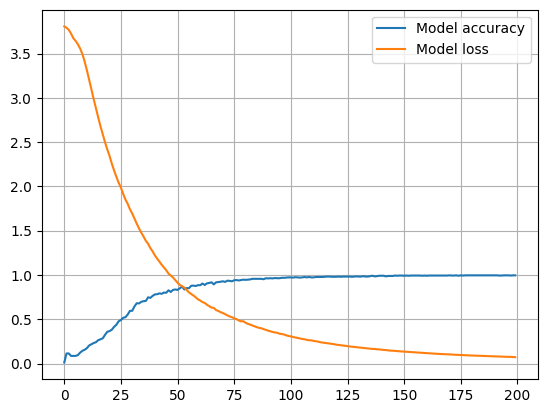

In [56]:
plt.plot(history.history['accuracy'], label = "Model accuracy")
plt.plot(history.history['loss'], label = "Model loss")
plt.legend()
plt.grid()

# Testing frenshi
Finally, let's chat with Frenshi a little bit about the administrative formalities in France for foreign students.

In [57]:
import random
while True:
  texts_p = []
  prediction_input = input("You: ")
  #Preprocessing the user's input
  prediction_input = [ltrs.lower() for ltrs in prediction_input if ltrs not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_inputTmp = prediction_input
  texts_p.append(prediction_input)
  #Tokenizing the user's input
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  #Apply padding
  prediction_input = pad_sequences([prediction_input], input_shape)
  #Perform prediction on user's input
  output = model.predict(prediction_input)
  output = output.argmax()
  #Convert model output back to text
  response_tag = labelEnc.inverse_transform([output])[0]
  #print the best answer to the user's input
  print("Frenshi: ", random.choice(responses[response_tag]))
  if response_tag == "goodbyeDay FR" or response_tag == "goodbyeEvening FR":
    break

You: Salut!
1/1 [==============================] - 0s 431ms/step
Frenshi:  Bonjour ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:
CAF, titre de séjour ou sécurité sociale
You: titre de séjour
1/1 [==============================] - 0s 26ms/step
Frenshi:  En France, le titre de séjour vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat.
You: Comment demander un titre de séjour
1/1 [==============================] - 0s 31ms/step
Frenshi:  Pour effectuer votre démarche de titre de séjour vous pouvez précéder à travers